In [1]:
import yaml
import requests
import io

import pandas

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib
import matplotlib.pyplot as plt

import evaluation

In [2]:
%matplotlib inline
matplotlib.style.use('ggplot')

# 0. Get Data

### Retrieve from Kaggle

#### Note:
    
This requires the user to set up a .yaml authentication file, with a *kaggle* field that contains within it *UserName* and *Password* (at least, that is what I've named my credential variables; I am not sure that they have to be named this way).

In [3]:
def get_kaggle_csv(url, creds_path='auth.yaml'):
    # get creds
    with open(creds_path) as f:
        creds = yaml.load(f)['kaggle']
        
    # initiate request to get file
    r = requests.get(url)
    
    # pass creds and complete retrieval
    data = requests.post(r.url,
                         data=creds).text
    
    # return DataFrame of csv
    return pandas.read_csv(io.StringIO(data))

In [4]:
url = 'https://www.kaggle.com/uciml/mushroom-classification/downloads/mushrooms.csv'

In [5]:
data = get_kaggle_csv(url)

### Quick Inspection

In [6]:
data.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


#### Check length; check for missing or duplicated data

In [7]:
len(data)

8124

In [8]:
data.isnull().sum()

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

In [9]:
len(data[data.duplicated()])

0

#### Confirm all data is categorical

In [10]:
for col in data.columns:
    print(data[col].unique())

['p' 'e']
['x' 'b' 's' 'f' 'k' 'c']
['s' 'y' 'f' 'g']
['n' 'y' 'w' 'g' 'e' 'p' 'b' 'u' 'c' 'r']
['t' 'f']
['p' 'a' 'l' 'n' 'f' 'c' 'y' 's' 'm']
['f' 'a']
['c' 'w']
['n' 'b']
['k' 'n' 'g' 'p' 'w' 'h' 'u' 'e' 'b' 'r' 'y' 'o']
['e' 't']
['e' 'c' 'b' 'r' '?']
['s' 'f' 'k' 'y']
['s' 'f' 'y' 'k']
['w' 'g' 'p' 'n' 'b' 'e' 'o' 'c' 'y']
['w' 'p' 'g' 'b' 'n' 'e' 'y' 'o' 'c']
['p']
['w' 'n' 'o' 'y']
['o' 't' 'n']
['p' 'e' 'l' 'f' 'n']
['k' 'n' 'u' 'h' 'w' 'r' 'o' 'y' 'b']
['s' 'n' 'a' 'v' 'y' 'c']
['u' 'g' 'm' 'd' 'p' 'w' 'l']


#### Look at counts of *edible* vs. *poisonous*

In [11]:
data['class'].value_counts()

e    4208
p    3916
Name: class, dtype: int64

# 1. Exploratory Analysis

### 1.A. Quick check for which features might provide the most insight 

#### Functions

In [12]:
def diff_between_groups(group_1, group_2):
    # outer join the two groups into one DataFrame
    # fill missing values with 0
    grouped = group_1.to_frame().join(group_2, 
                                      rsuffix='_', 
                                      how='outer').fillna(0)
    
    # scale counts to be proportionte to the total in each group
    grouped = grouped / grouped.sum()
    
    # get difference between scaled values in each group
    diff = grouped[grouped.columns[0]] - \
                grouped[grouped.columns[1]]
    
    # return average squared differences
    return (diff ** 2).mean()

In [13]:
def get_groups(df, col):
    # return dataframe[col] filtered by each class value
    return df[df['class']=='e'][col].value_counts(), \
                df[df['class']=='p'][col].value_counts()

#### Get differences, sort

In [14]:
diff = []
for col in data.columns[1:]:
    diff.append((col, 
                 diff_between_groups(*get_groups(data, 
                                               col))))

sorted_diff = \
        sorted(diff, 
               key = lambda tup: tup[1],
               reverse=True)

#### Look at top 5 most different

In [15]:
sorted_diff[:5]

[('gill-size', 0.24948565575061857),
 ('bruises', 0.24467478772253914),
 ('stalk-surface-above-ring', 0.128270415429778),
 ('stalk-surface-below-ring', 0.11163432018615214),
 ('odor', 0.10884075521038676)]

#### Look further into top 2 most different

In [16]:
group_1, group_2 = get_groups(data, 'gill-size')

In [17]:
pandas.concat([pandas.concat({'e': group_1}),
               pandas.concat({'p': group_2})])

e  b    3920
   n     288
p  n    2224
   b    1692
Name: gill-size, dtype: int64

In [18]:
group_1, group_2 = get_groups(data, 'bruises')

In [19]:
pandas.concat([pandas.concat({'e': group_1}),
               pandas.concat({'p': group_2})])

e  t    2752
   f    1456
p  f    3292
   t     624
Name: bruises, dtype: int64

### 1.B. Visualize the relationsips between each of *gill-sizes* and *bruises*, and *class*

#### Visualize relationship between *gill-size* and *class*

In [20]:
group_1, group_2 = get_groups(data, 'gill-size')

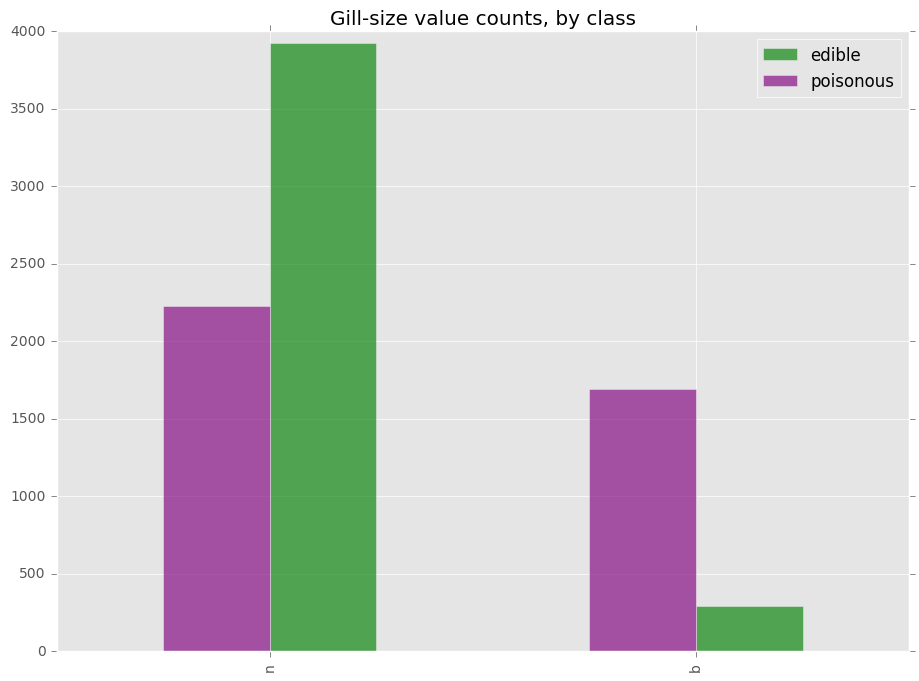

In [21]:
ax = group_1.plot(kind='bar',
                  figsize=(11, 8),
                  color='g',
                  alpha=.65,
                  position=0,
                  width=.25,
                  label='edible')

group_2.plot(kind='bar',
              figsize=(11, 8),
              color='purple',
              alpha=.65,
              position=1,
              width=.25,
              label='poisonous',
              ax=ax)

ax.set_xlim(right=1.5)
plt.legend()
plt.title('Gill-size value counts, by class')

#### Visualize relationship between *bruises* and *class*

In [22]:
group_1, group_2 = get_groups(data, 'bruises')

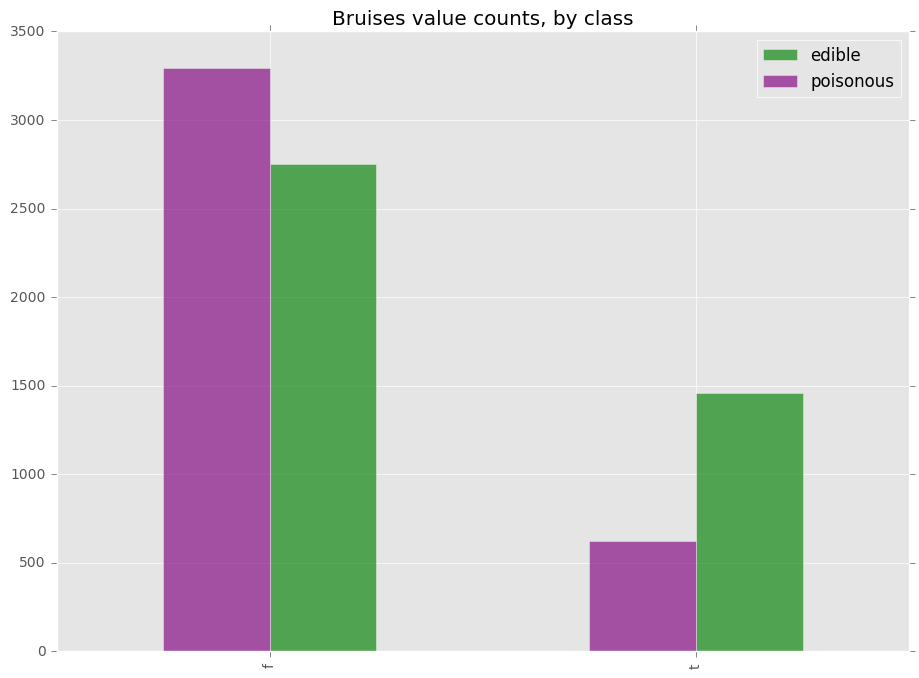

In [23]:
ax = group_1.plot(kind='bar',
                  figsize=(11, 8),
                  color='g',
                  alpha=.65,
                  position=0,
                  width=.25,
                  label='edible')

group_2.plot(kind='bar',
              figsize=(11, 8),
              color='purple',
              alpha=.65,
              position=1,
              width=.25,
              label='poisonous',
              ax=ax)

ax.set_xlim(right=1.5)
plt.legend()
plt.title('Bruises value counts, by class')

#### Note:
    
Since these two features seem to be fairly indicative of whether or not a mushroom is poisonous, let's try to cluster our data set into two groups based on these features. We will then see whether our cluster labels prove informative.

### 1.C. Clustering

#### one-hot encode data

In [24]:
onehot = pandas.get_dummies(data)

In [25]:
onehot.columns

Index(['class_e', 'class_p', 'cap-shape_b', 'cap-shape_c', 'cap-shape_f',
       'cap-shape_k', 'cap-shape_s', 'cap-shape_x', 'cap-surface_f',
       'cap-surface_g',
       ...
       'population_s', 'population_v', 'population_y', 'habitat_d',
       'habitat_g', 'habitat_l', 'habitat_m', 'habitat_p', 'habitat_u',
       'habitat_w'],
      dtype='object', length=119)

In [26]:
top_two = [col for col in onehot.columns if 'gill-sizes' in col or 'bruises' in col]

#### k-means: *gill-size* and *bruises*

In [27]:
kmeans = KMeans(n_clusters=2)

In [28]:
kmeans.fit(onehot[top_two])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [29]:
data['cluster_kmeans_1'] = kmeans.labels_

In [30]:
grouped = \
    data.groupby(['class', 
                  'cluster_kmeans_1']).size().to_frame().rename(columns={0: 'counts'})
grouped / grouped.sum()

counts
class cluster_kmeans_1          
e     0                 0.338749
      1                 0.179222
p     0                 0.076809
      1                 0.405219

#### Note:
    
It seems that the clusters assigned to our data points come pretty close (no pun intented) to separating the data points based on their class. Let's feed in more features and see if we can get an even better representation.

#### k-means: all columns except for class columns

In [31]:
kmeans = KMeans(n_clusters=2)

In [32]:
cols = [col for col in onehot.columns if 'class' not in col]

In [33]:
kmeans.fit(onehot[cols])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [34]:
data['cluster_kmeans_2'] = kmeans.labels_

In [35]:
grouped = \
    data.groupby(['class', 
                  'cluster_kmeans_2']).size().to_frame().rename(columns={0: 'counts'})
grouped / grouped.sum()

counts
class cluster_kmeans_2          
e     0                 0.510586
      1                 0.007386
p     0                 0.100443
      1                 0.381585

#### Note:
    
These results are even better than before. It seems like Euclidean distance here is serving us well. Let's go ahead and try to predict *class* using k-Nearest Neighbor classification.

# 2. Predict *class*

### 2.A. k-Nearest Neighbors

In [36]:
evaluation.five_fold_validation(KNeighborsClassifier, 
                                onehot[cols],
                                onehot['class_p'],
                                'clf',
                                [{'n_neighbors': x} for x in range(1, 6)])

train_accuracy  test_accuracy  test_precision  \
trial params                                                          
1     n_neighbors: 1             1.0            1.0             1.0   
      n_neighbors: 2             1.0            1.0             1.0   
      n_neighbors: 3             1.0            1.0             1.0   
      n_neighbors: 4             1.0            1.0             1.0   
      n_neighbors: 5             1.0            1.0             1.0   
2     n_neighbors: 1             1.0            1.0             1.0   
      n_neighbors: 2             1.0            1.0             1.0   
      n_neighbors: 3             1.0            1.0             1.0   
      n_neighbors: 4             1.0            1.0             1.0   
      n_neighbors: 5             1.0            1.0             1.0   
3     n_neighbors: 1             1.0            1.0             1.0   
      n_neighbors: 2             1.0            1.0             1.0   
      n_neighbors: 3             1.0            1.0             1.0   
      n_neighbors: 4             1.0            1.0             1.0   
      n_neighbors: 5             1.0            1.0             1.0   
4     n_neighbors: 1             1.0            1.0             1.0   
      n_neighbors: 2             1.0            1.0             1.0   
      n_neighbors: 3             1.0            1.0             1.0   
      n_neighbors: 4             1.0            1.0             1.0   
      n_neighbors: 5             1.0            1.0             1.0   
5     n_neighbors: 1             1.0            1.0             1.0   
      n_neighbors: 2             1.0            1.0             1.0   
      n_neighbors: 3             1.0            1.0             1.0   
      n_neighbors: 4             1.0            1.0             1.0   
      n_neighbors: 5             1.0            1.0             1.0   

                      test_recall  test_f1score  
trial params                                     
1     n_neighbors: 1          1.0           1.0  
      n_neighbors: 2          1.0           1.0  
      n_neighbors: 3          1.0           1.0  
      n_neighbors: 4          1.0           1.0  
      n_neighbors: 5          1.0           1.0  
2     n_neighbors: 1          1.0           1.0  
      n_neighbors: 2          1.0           1.0  
      n_neighbors: 3          1.0           1.0  
      n_neighbors: 4          1.0           1.0  
      n_neighbors: 5          1.0           1.0  
3     n_neighbors: 1          1.0           1.0  
      n_neighbors: 2          1.0           1.0  
      n_neighbors: 3          1.0           1.0  
      n_neighbors: 4          1.0           1.0  
      n_neighbors: 5          1.0           1.0  
4     n_neighbors: 1          1.0           1.0  
      n_neighbors: 2          1.0           1.0  
      n_neighbors: 3          1.0           1.0  
      n_neighbors: 4          1.0           1.0  
      n_neighbors: 5          1.0           1.0  
5     n_neighbors: 1          1.0           1.0  
      n_neighbors: 2          1.0           1.0  
      n_neighbors: 3          1.0           1.0  
      n_neighbors: 4          1.0           1.0  
      n_neighbors: 5          1.0           1.0

#### Note:
    
These results are ridiculously good. The fact that test accuracy was just as high as training accuracy would usually be a good indicator of a model's non-overfitedness (sorry, that was not very eloquent), but the fact that this model is literally perfect is a bit worrying. 

It could be that this data set is just very clean and robust, and that *class* is well-predicted via k-Nearest Neighbor. Unfortunately I know almost nothing about mushrooms, so any insight that might typically be gleaned through an understanding of the problem space is at this point not within reach. 

It would be good to do some further investigations. We could reduce complexity by increasing the number of neighbors considered, and we could also reduce the number of folds tested across to allow for more test data. But, this model is already taking some time to test as is, so let's move on to some other model families.

### 2.B. Logistic Regression

In [37]:
evaluation.five_fold_validation(LogisticRegression, 
                                onehot[cols],
                                onehot['class_p'],
                                'clf')

,,train_accuracy,test_accuracy,test_precision,test_recall,test_f1score
trial,params,,,,,
1,Default,1.0,1.000000,1.0,1.000000,1.000000
2,Default,1.0,1.000000,1.0,1.000000,1.000000
3,Default,1.0,1.000000,1.0,1.000000,1.000000
4,Default,1.0,1.000000,1.0,1.000000,1.000000
5,Default,1.0,0.998153,1.0,0.996169,0.998081


#### Note:
    
Using a linear model has also given perfect or near-perfect results. Let's try to reduce the number of features used and see if we can still make good predicitions. 

In [38]:
new_cols = [col for col in onehot.columns if 'gill-size' in col or 'bruises' in col]

In [39]:
evaluation.five_fold_validation(LogisticRegression, 
                                onehot[new_cols],
                                onehot['class_p'],
                                'clf')

,,train_accuracy,test_accuracy,test_precision,test_recall,test_f1score
trial,params,,,,,
1,Default,0.761619,0.776753,0.707799,0.914541,0.797997
2,Default,0.766118,0.758769,0.688162,0.913155,0.784852
3,Default,0.767195,0.754462,0.688235,0.896552,0.778702
4,Default,0.756462,0.755542,0.889113,0.563218,0.689601
5,Default,0.760154,0.740764,0.863454,0.549170,0.671351


#### Note:
    
Using only *gill-size* and *bruises* to predict class has proven somewhat effective, but we have seen a severe reduction in performance. Interestingly, we can see, given the differences between precision and recall and their disparity across these trials, that there appears to be a distinct portion of the data for which these features are not helpful for classification (which you can see if you look back at our grouping check above).

Let's try also including our previously-calculated clusters as features.

In [40]:
onehot['cluster_kmeans_2'] = data['cluster_kmeans_2']

In [41]:
new_cols.append('cluster_kmeans_2')

In [42]:
evaluation.five_fold_validation(LogisticRegression, 
                                onehot[new_cols],
                                onehot['class_p'],
                                'clf')

,,train_accuracy,test_accuracy,test_precision,test_recall,test_f1score
trial,params,,,,,
1,Default,0.912435,0.914514,0.964029,0.854592,0.906018
2,Default,0.910294,0.923077,0.966006,0.871009,0.916051
3,Default,0.913987,0.908308,0.952857,0.851852,0.899528
4,Default,0.913692,0.909483,0.945378,0.862069,0.901804
5,Default,0.913846,0.908867,0.950355,0.855683,0.900538


#### Note:
    
Using only these three features (one of which is nevertheless quite derived) has allowed us to consistently classify these mushrooms as poisonous or not with an accuracy of greater than 90%.

Interestingly, there is a tangible difference here between the model's precision and recall scores. We can see here that the model is careful when it comes to making falsely positive classifications. But that comes at the expense of its carefulness with respect to making falsely negative classifications. Seeing as how, based on how I've set this up, *poisonous* is our positive class, we would want to be careful using this model for the purpose of deciding whether or not to eat a mushroom. 

Just for fun, let's try to classify based on only a datapoint's cluster.

In [43]:
evaluation.five_fold_validation(LogisticRegression, 
                                onehot['cluster_kmeans_2'].to_frame(),
                                onehot['class_p'],
                                'clf')

,,train_accuracy,test_accuracy,test_precision,test_recall,test_f1score
trial,params,,,,,
1,Default,0.892890,0.889299,0.985531,0.781888,0.871977
2,Default,0.890445,0.899077,0.984351,0.803321,0.884669
3,Default,0.893060,0.888615,0.983923,0.781609,0.871174
4,Default,0.893231,0.887931,0.967341,0.794381,0.872370
5,Default,0.891231,0.895936,0.984227,0.796935,0.880734


#### Note:
    
Our accuracy has dipped slightly, though it is still close to 90%. But we can see that the disparity between precision and recall has become much more pronouced.

Let's go ahead and implement some regularization.

In [44]:
evaluation.five_fold_validation(LogisticRegression, 
                                onehot[cols],
                                onehot['class_p'],
                                'clf',
                                [{'C': x} for x in (.01, .1, 1)])

train_accuracy  test_accuracy  test_precision  test_recall  \
trial params                                                                
1     C: 0.01        0.985072       0.980320        0.989583     0.969388   
      C: 0.1         0.998307       0.999385        1.000000     0.998724   
      C: 1           1.000000       1.000000        1.000000     1.000000   
2     C: 0.01        0.983690       0.987077        0.990979     0.982120   
      C: 0.1         0.998923       0.999385        1.000000     0.998723   
      C: 1           1.000000       1.000000        1.000000     1.000000   
3     C: 0.01        0.984459       0.983385        0.989637     0.975734   
      C: 0.1         0.999077       0.998154        1.000000     0.996169   
      C: 1           1.000000       1.000000        1.000000     1.000000   
4     C: 0.01        0.983846       0.985222        0.988417     0.980843   
      C: 0.1         0.998923       0.999384        1.000000     0.998723   
      C: 1           1.000000       1.000000        1.000000     1.000000   
5     C: 0.01        0.984769       0.983990        0.994771     0.971903   
      C: 0.1         0.998923       0.995690        1.000000     0.991060   
      C: 1           1.000000       0.998153        1.000000     0.996169   

               test_f1score  
trial params                 
1     C: 0.01      0.979381  
      C: 0.1       0.999362  
      C: 1         1.000000  
2     C: 0.01      0.986530  
      C: 0.1       0.999361  
      C: 1         1.000000  
3     C: 0.01      0.982637  
      C: 0.1       0.998081  
      C: 1         1.000000  
4     C: 0.01      0.984615  
      C: 0.1       0.999361  
      C: 1         1.000000  
5     C: 0.01      0.983204  
      C: 0.1       0.995510  
      C: 1         0.998081

#### Note:
    
Even if we force our coefficients to stay near 0, we still see Logistic Regression performing quite well. 

An L2 regularization of .01 indicates some generalizability to the model. Additionally, we can see a slight tendancy towards precision, at the expsense of recall, but overall this model seems to be performing in a balanced fashion.

What if we allow some coefficients to go all the way to 0?

In [45]:
evaluation.five_fold_validation(LogisticRegression, 
                                onehot[cols],
                                onehot['class_p'],
                                'clf',
                                [{'C': x, 'penalty': 'l1'} for x in (.01, .1, 1)])

train_accuracy  test_accuracy  test_precision  \
trial params                                                                
1     C: 0.01, penalty: l1        0.977224       0.977860        0.979487   
      C: 0.1, penalty: l1         0.997999       0.998155        1.000000   
      C: 1, penalty: l1           1.000000       1.000000        1.000000   
2     C: 0.01, penalty: l1        0.975996       0.982769        0.982120   
      C: 0.1, penalty: l1         0.997846       0.998769        1.000000   
      C: 1, penalty: l1           1.000000       1.000000        1.000000   
3     C: 0.01, penalty: l1        0.977997       0.974769        0.970812   
      C: 0.1, penalty: l1         0.998000       0.998154        1.000000   
      C: 1, penalty: l1           1.000000       1.000000        1.000000   
4     C: 0.01, penalty: l1        0.976769       0.979680        0.977099   
      C: 0.1, penalty: l1         0.997692       0.999384        1.000000   
      C: 1, penalty: l1           1.000000       1.000000        1.000000   
5     C: 0.01, penalty: l1        0.978769       0.971675        0.968234   
      C: 0.1, penalty: l1         0.998615       0.995690        1.000000   
      C: 1, penalty: l1           0.999846       0.998153        1.000000   

                            test_recall  test_f1score  
trial params                                           
1     C: 0.01, penalty: l1     0.974490      0.976982  
      C: 0.1, penalty: l1      0.996173      0.998083  
      C: 1, penalty: l1        1.000000      1.000000  
2     C: 0.01, penalty: l1     0.982120      0.982120  
      C: 0.1, penalty: l1      0.997446      0.998721  
      C: 1, penalty: l1        1.000000      1.000000  
3     C: 0.01, penalty: l1     0.977011      0.973902  
      C: 0.1, penalty: l1      0.996169      0.998081  
      C: 1, penalty: l1        1.000000      1.000000  
4     C: 0.01, penalty: l1     0.980843      0.978967  
      C: 0.1, penalty: l1      0.998723      0.999361  
      C: 1, penalty: l1        1.000000      1.000000  
5     C: 0.01, penalty: l1     0.973180      0.970701  
      C: 0.1, penalty: l1      0.991060      0.995510  
      C: 1, penalty: l1        0.996169      0.998081

#### Note:

Applying L1 regularization yields similar results to those produced with L2 regularization, though for the same regularization values L2 seems to yield slightly better results.
    
The results produced via Logistic Regression look very promising. Passing all of the dataset's original columns (excluding *class* of course) as features has produced a model that is maybe just the smidgeniest of smidgens less accurate than k-Nearest Neighbor, while testing at a higher speed. Applying regularization, which reduces model complexity and increases the model's generalizability, still resulted in a very accurate model. At this point, it might be nice to give this one a 'good job!' and move on to some other experimentations.

The binomial nature of our various features means that this data could possibly be well-classified by a Bernoulli Naive Bayes classifier, so let's go ahead and give that a try. 

### 2.C. Navie Bayes: Bernoulli

In [46]:
evaluation.five_fold_validation(BernoulliNB, 
                                onehot[cols],
                                onehot['class_p'],
                                'clf',
                                [{'alpha': x} for x in (.01, .1, 1, 10)])

train_accuracy  test_accuracy  test_precision  test_recall  \
trial params                                                                    
1     alpha: 0.01        0.976608       0.976015        0.997330     0.952806   
      alpha: 0.1         0.958295       0.958180        0.995845     0.917092   
      alpha: 1           0.941982       0.931734        0.989811     0.867347   
      alpha: 10          0.925362       0.912669        0.983434     0.832908   
2     alpha: 0.01        0.977073       0.980923        0.989583     0.970626   
      alpha: 0.1         0.958455       0.964923        0.989218     0.937420   
      alpha: 1           0.938760       0.947077        0.986053     0.902937   
      alpha: 10          0.920449       0.927385        0.975680     0.871009   
3     alpha: 0.01        0.975842       0.979692        0.992126     0.965517   
      alpha: 0.1         0.959224       0.958154        0.990398     0.922095   
      alpha: 1           0.940299       0.937231        0.984353     0.883780   
      alpha: 10          0.920911       0.921231        0.973951     0.859515   
4     alpha: 0.01        0.978154       0.971675        0.977951     0.962963   
      alpha: 0.1         0.959692       0.953202        0.977058     0.924649   
      alpha: 1           0.941077       0.935345        0.973464     0.890166   
      alpha: 10          0.921692       0.917488        0.968254     0.856960   
5     alpha: 0.01        0.978308       0.978448        0.989529     0.965517   
      alpha: 0.1         0.959692       0.964901        0.989218     0.937420   
      alpha: 1           0.940462       0.947044        0.987413     0.901660   
      alpha: 10          0.920000       0.927956        0.977077     0.871009   

                   test_f1score  
trial params                     
1     alpha: 0.01      0.974560  
      alpha: 0.1       0.954847  
      alpha: 1         0.924541  
      alpha: 10        0.901934  
2     alpha: 0.01      0.980013  
      alpha: 0.1       0.962623  
      alpha: 1         0.942667  
      alpha: 10        0.920378  
3     alpha: 0.01      0.978641  
      alpha: 0.1       0.955026  
      alpha: 1         0.931359  
      alpha: 10        0.913161  
4     alpha: 0.01      0.970399  
      alpha: 0.1       0.950131  
      alpha: 1         0.929953  
      alpha: 10        0.909214  
5     alpha: 0.01      0.977376  
      alpha: 0.1       0.962623  
      alpha: 1         0.942590  
      alpha: 10        0.920999

#### Note:
    
This model performs well, but not quite as well as either of the previous models we tested. As expected, performance went down as we decreased model complexity. Let's move on to some tree-based models.

### 2.D. Decision Tree

In [47]:
evaluation.five_fold_validation(DecisionTreeClassifier, 
                                onehot[cols],
                                onehot['class_p'],
                                'clf')

,,train_accuracy,test_accuracy,test_precision,test_recall,test_f1score
trial,params,,,,,
1,Default,1.0,1.000000,1.0,1.000000,1.000000
2,Default,1.0,1.000000,1.0,1.000000,1.000000
3,Default,1.0,1.000000,1.0,1.000000,1.000000
4,Default,1.0,1.000000,1.0,1.000000,1.000000
5,Default,1.0,0.998153,1.0,0.996169,0.998081


#### Note:
    
These results are phenomenal, maybe too phenomenal. Let's limit tree depth and see what happens.

In [48]:
evaluation.five_fold_validation(DecisionTreeClassifier, 
                                onehot[cols],
                                onehot['class_p'],
                                'clf',
                                [{'max_depth': 4}])

,,train_accuracy,test_accuracy,test_precision,test_recall,test_f1score
trial,params,,,,,
1,max_depth: 4,0.987073,0.980320,1.000000,0.959184,0.979167
2,max_depth: 4,0.993076,0.995692,0.991139,1.000000,0.995550
3,max_depth: 4,0.994615,0.989538,0.979950,0.998723,0.989247
4,max_depth: 4,0.993692,0.993227,0.986146,1.000000,0.993025
5,max_depth: 4,0.994923,0.988300,0.979899,0.996169,0.987967


#### Note:
    
Accuracy has decreased slightly but is still very, very good. The intermitent disparities between train and test accuracy could indicate a propensity for variance in the predictions / overfitting. Let's train a tree and look at what features it is using to make predictions.

In [49]:
X_train, X_test, y_train, y_test = train_test_split(onehot[cols], onehot['class_p'])

In [50]:
clf = DecisionTreeClassifier(max_depth=4).fit(X_train, y_train)

In [51]:
clf.score(X_test, y_test)

0.99261447562776961

In [52]:
col_importances = []
for i, col in enumerate(cols):
    col_importances.append((col, clf.feature_importances_[i]))

In [53]:
sorted(col_importances, key=lambda tup: tup[1], reverse=True)[:5]

[('odor_n', 0.63537621229013563),
 ('stalk-root_c', 0.18088877145300622),
 ('stalk-surface-below-ring_y', 0.099011067162175156),
 ('spore-print-color_r', 0.034623923396534681),
 ('odor_a', 0.024676952349263506)]

#### Note:
    
The presence, or lack thereof, of the value *n* for feautre *odor* seemed to be quite useful for the Decision Tree. Let's go ahead and train a Random Forest classifier, which, in reducing overfitting, should provide us with more even feature importances.

### 2.E. Random Forest

In [54]:
clf = RandomForestClassifier(n_estimators=10, max_depth=4, n_jobs=-1).fit(X_train, y_train)

In [55]:
clf.score(X_test, y_test)

0.98424421467257506

#### Note:
    
Our accuracy here is lower than that of the single Decision Tree we trained above. We may be able to increase model accuracy through increasing the number of trees used.

In [56]:
clf = RandomForestClassifier(n_estimators=100, max_depth=4, n_jobs=-1).fit(X_train, y_train)

In [57]:
clf.score(X_test, y_test)

0.99064500246184151

In [58]:
col_importances = []
for i, col in enumerate(cols):
    col_importances.append((col, clf.feature_importances_[i]))

In [59]:
sorted(col_importances, key=lambda tup: tup[1], reverse=True)[:5]

[('odor_n', 0.13361282813574549),
 ('odor_f', 0.085905623830595648),
 ('gill-size_n', 0.061650278355427107),
 ('stalk-surface-above-ring_k', 0.061191344563853514),
 ('stalk-surface-below-ring_k', 0.053571920521429804)]

#### Note:
    
Increasing the number of trees used increased our accuracy noticeably. *odor-n* is still the most important feature, though much less domineering in its importance.

# 3. Analysis

#### All models tested produced results that in many contexts would be considered quite good.

This data responded well to utilizations of Euclidean distance. k-Means provided a succfessful avenue to decomposition.

k-Nearest Neighbor produced perfect results across multiple tests, but that may have been due to overfitting. Due to the increasing wait times involved in increasing the number of neighbors considered (which improves generalizability), we moved on to other models.

Bernoulli Naive Bayes was less accuracte than the other models.

A Decision Tree produced high accuracy but may have been overfitting. A Random Forest was then tested. This proved highly accuracte. But the Random Forest is more of a black-box model, as evidenced by the wait involed in even printing out some feature importances.

That leaves Logistic Regression. This model proved highly accurate, very tweakable, and quick to train and test. Precomputing a *cluster* feature using k-Means provided an additional, highly predictive feature. As its ubiquity throughout a variety of different modeling applications might suggest, Logistic Regression is a powerful model.